In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import os
import sys
from scipy.ndimage import gaussian_filter1d
from scipy.signal import convolve
from brian2 import *

In [3]:
sys.path.append("../lib") # add code library to paths

# add lib to path 
from model_beta import Model

In [4]:
# TODO: turn this into  script

In [5]:
netname = 'forward_nn'
model = Model(netname)  # initiate the model


../output/forward_nn


In [6]:
params = {
'sig_c' : 0.05  ,    # bipolar receptive fied size ~ 1/5 of the actual size [mm]
'tau1' : 0.04   ,    # excitation time constant of the temporal filter [s]
'tau2' : 0.0876 ,    # rebound time constant [s]
'bifw' : 0.     ,    # relative weight of rebound/excitation [1]

'scale_mV' : 20.,     # UPDATED 

'tauA' : 0.15   ,     # time constant of amacrine cells [s]
'tauB' : 0.08   ,     # time constant of bipolar cells [s]
'tauG' : 0.01   ,     # time contant of ganglion cells [s]

'wAB' : 10.     ,     # synaptic weight from bipolar to amacrine [Hz]
'wBA' : 0.    ,     # synaptic weight from amacrine to bipolar [Hz]
'wGB' : 4.0     ,     # synaptic weight from bipolar to gangion  [Hz].   #UPDATED
'wGA' : -2.0      ,     # synaptic weight from amacrine  to gangion  [Hz]

'slope' : 5     ,     # slope for ganglion cell recritifation [Hz/mV].   #UPDATED
'threshold' : 0 ,     # threshold for ganglion cell recritifation [Hz/mV]
'sig_pool' : 0.065 ,  # sigma for gaussian pooling in ganlion gells [mm]


'spacing' : 0.005  ,  # spacing of cells on the lattice [mm]
'dt' : 0.001      ,   # integration time step [s]
'N' : 512          ,  # number of neurons in each layer [1]


# idx = int(N/2)
# b =  0.160         # half bar width [mm]
# speed =  0.8       # speed [mm/s]  
}

In [7]:

# create connectivity matrix TODO write a class for this !!!

C = np.zeros((params['N'],params['N']))
ii = np.arange(0,params['N']-1,1).astype(int)  # list of source cells for rightward connections
ji = ii + 1                          # target cells of rightward connections


C[ii,ji] = 1

ii = np.arange(1,params['N'],1).astype(int)    # list of source cells for leftward connections
ji = ii - 1                         # target cells of leftward connections

C[ii,ji] = 1


In [8]:

model.set_params(params)
model.set_connectivity(C)


# simulate response to moving bar at one speed

In [9]:

# function to make bar stimulus
def bar(t, x, b, v):

    if x >=-b+v*t and x <=b+v*t :
        return 1
    else:
        return 0


speed = 0.8
b = 0.16
L = params['N']*params['spacing']
dt = params['dt']
dur = L/speed                 # duration of the simulation [s]
tps = int(dur/params['dt'])             # number of time-points in the simulation [1]

# # #enfroce tps to pe power of 2 
# import math
# # pow = np.floor(math.log2(tps))+1
# # tps = int(2**pow)
# # print(pow,tps)
# pow = np.floor(math.log2(tps))
# tps = int(2**pow)
# dt = dur/tps


time = np.arange(0,tps)*dt    # time array for the simulation 1xtps, in [s]


# make bar stimulus
barstim = np.zeros((params['N'],tps))

for n in range(params['N']):
    for ti in range(tps):
        xi = n*params['spacing']
        barstim[n,ti] = bar(ti*dt,xi,b,speed)


S = barstim

print(S.shape,L)

(512, 3199) 2.56


In [10]:
model.set_stimulus(S,f'bar_{speed}')
model.simulate()

../output/forward_nn/bar_0.8


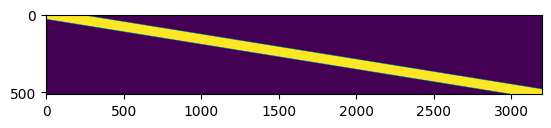

In [11]:
plt.imshow(S)

# simulate response for multiple speeds

In [12]:
# loop over speeds 
speeds = np.round(np.arange(0.1,1.1,0.1),1)

for s in speeds: 
    
    dur = L/s                 # duration of the simulation [s]
    tps = int(dur/params['dt'])             # number of time-points in the simulation [1]
    # print(tps)
    # #enfroce tps to pe power of 2 
    # import math
    # # pow = np.floor(math.log2(tps))+1
    # # tps = int(2**pow)
    # # print(pow,tps)
    # pow = np.floor(math.log2(tps))
    # tps = int(2**pow)
    # dt = dur/tps


    time = np.arange(0,tps)*dt    # time array for the simulation 1xtps, in [s]


    # make bar stimulus
    barstim = np.zeros((params['N'],tps))

    for n in range(params['N']):
        for ti in range(tps):
            xi = n*params['spacing']
            barstim[n,ti] = bar(ti*dt,xi,b,s)

    S = barstim
    # print(S.shape)
    stimname = f'bar_{s}'
    model.set_stimulus(S,stimname)
    model.simulate()

../output/forward_nn/bar_0.1
../output/forward_nn/bar_0.2
../output/forward_nn/bar_0.3
../output/forward_nn/bar_0.4
../output/forward_nn/bar_0.5
../output/forward_nn/bar_0.6
../output/forward_nn/bar_0.7
../output/forward_nn/bar_0.8
../output/forward_nn/bar_0.9
../output/forward_nn/bar_1.0


In [26]:

t_bars = []

t_max_Gs = []
t_max_Bs = []

t_shift_Gs = []
t_shift_Bs = []

ant_Gs = []
ant_Bs = []

v_max_Gs = []
v_max_Bs = []

for s in speeds:

    stimname = f'bar_{s}'
    sigB = np.load(f'../output/{netname}/{stimname}/BC_grid_{stimname}.npy')
    sigA = np.load(f'../output/{netname}/{stimname}/AC_grid_{stimname}.npy')
    sigG = np.load(f'../output/{netname}/{stimname}/GC_grid_{stimname}.npy')
    stim = np.load(f'../output/{netname}/{stimname}/stim_grid_{stimname}.npy')

    N = 206                   # choolse middle cell
    x = N * params['spacing'] # calculate cell position
    t_bar = x/s               # calculate t_bar

    print(x,t_bar,s)
    t_max_G = np.argmax(sigG[N,:])*params['dt'] # measure t_max
    t_max_B = np.argmax(sigB[N,:])*params['dt'] # measure t_max
    

    t_shift_G = t_bar-t_max_G # measure peah shift
    t_shift_B = t_bar-t_max_B # measure peah shift
    
    
    ant_G = t_shift_G*s     # calculate anticipation
    ant_B = t_shift_B*s     # calculate anticipation

    
    v_max_G = np.max(sigG[N,:])  # measure max
    v_max_B = np.max(sigB[N,:])  # measure max

    
    t_bars.append(t_bar)
    t_max_Gs.append(t_max_G)
    t_max_Bs.append(t_max_B)
    
    t_shift_Gs.append(t_shift_G)
    t_shift_Bs.append(t_shift_B)
    
    ant_Gs.append(ant_G)
    ant_Bs.append(ant_B)
    
    v_max_Gs.append(v_max_G)
    v_max_Bs.append(v_max_B)
    
    
# TODO   
# make df
# save as a separate file
    


1.03 10.299999999999999 0.1
1.03 5.1499999999999995 0.2
1.03 3.4333333333333336 0.3
1.03 2.5749999999999997 0.4
1.03 2.06 0.5
1.03 1.7166666666666668 0.6
1.03 1.4714285714285715 0.7
1.03 1.2874999999999999 0.8
1.03 1.1444444444444444 0.9
1.03 1.03 1.0


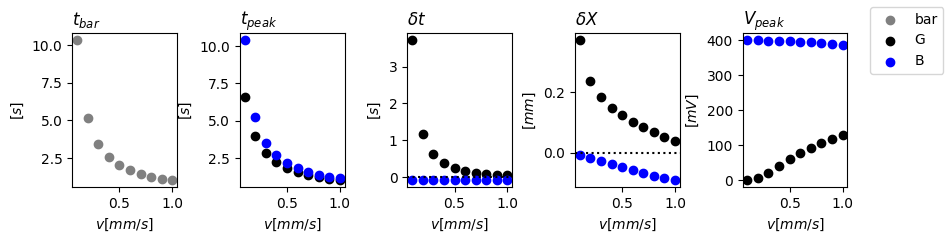

In [35]:
# TODO: copy this to plot file
fig = plt.figure(figsize = (10,2))
gs = fig.add_gridspec(1,5)
fig.subplots_adjust(wspace = 0.6)

ax = fig.add_subplot(gs[0,0])
ax.scatter(speeds,t_bars,label = 'bar', color = 'grey')
ax.set_title('$t_{bar}$', loc = 'left')
ax.set_xlabel('$v [mm/s]$')
ax.set_xlabel('$v [mm/s]$')
ax.set_ylabel('$[s]$')

ax = fig.add_subplot(gs[0,1])
ax.scatter(speeds,t_max_Gs, label = 'G', color = 'k')
ax.scatter(speeds,t_max_Bs, label = 'B', color = 'b')
ax.set_title('$t_{peak}$', loc = 'left')
ax.set_xlabel('$v [mm/s]$')
ax.set_ylabel('$[s]$')



ax = fig.add_subplot(gs[0,2])
ax.scatter(speeds,t_shift_Gs, color = 'k')
ax.scatter(speeds,t_shift_Bs, color = 'b')
ax.axhline(0,color = 'k', linestyle = ':')
ax.set_title('$\delta t$', loc = 'left')
ax.set_xlabel('$v [mm/s]$')
ax.set_ylabel('$[s]$')



ax = fig.add_subplot(gs[0,3])
ax.scatter(speeds,ant_Gs, color = 'k')
ax.scatter(speeds,ant_Bs, color = 'b')
ax.axhline(0,color = 'k', linestyle = ':')
ax.set_title('$\delta X$', loc = 'left')
ax.set_xlabel('$v [mm/s]$')
ax.set_ylabel('$[mm]$')



ax = fig.add_subplot(gs[0,4])
ax.scatter(speeds,v_max_Gs, color = 'k')
ax.scatter(speeds,v_max_Bs, color = 'b')
ax.set_title('$V_{peak} $', loc = 'left')
ax.set_xlabel('$v [mm/s]$')
ax.set_ylabel('$[mV]$')

fig.legend()

# loop over parameter and extract peak, anticipation, preferred speed 